In [15]:
%pip install pypinyin

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\tbhro\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [16]:
from __future__ import annotations
from collections import Counter, defaultdict
from typing import Dict, Iterable
from pypinyin import pinyin, Style

import pandas as pd

In [17]:
dataframe = pd.read_csv("C:\\Users\\tbhro\\PycharmProjects\\nlp-bpc\\zho_data\\sample_text.csv", encoding="utf-8")
zho_text = dataframe["text"].tolist()
# print(zho_text)
# Remove \r\n from each string in the zho_text list
zho_text_cleaned = [text.replace("\r\n", "") for text in zho_text]
# print(zho_text_cleaned)


In [18]:
# train
def is_chinese_char(ch: str) -> bool:
    """Rudimentary check if ch is a CJK Unified Ideograph."""
    return "\u4e00" <= ch <= "\u9fff"


def char_to_initial(ch: str) -> str | None:
    """
    Convert a single Chinese character to the first letter of its pinyin.
    Example: '我' -> 'w', '要' -> 'y'
    Returns None if pinyin can't be obtained.
    """
    if not is_chinese_char(ch):
        return None

    py_list = pinyin(ch, style=Style.NORMAL, strict=False)
    if not py_list or not py_list[0]:
        return None

    syllable = py_list[0][0]  # e.g. 'wo', 'yao', 'shui'
    return syllable[0].lower()  # first letter: 'w', 'y', 's', 'j', ...


def build_initial_to_char_counts(texts: Iterable[str]) -> Dict[str, Counter]:
    """
    Build a frequency table:
    initial_letter -> Counter({character: count, ...})
    from an iterable of Chinese texts.
    """
    mapping: Dict[str, Counter] = defaultdict(Counter)

    for text in texts:
        for ch in text:
            if not is_chinese_char(ch):
                continue
            initial = char_to_initial(ch)
            if initial is None:
                continue
            mapping[initial][ch] += 1

    return mapping

In [19]:
# decoding  
def build_initial_to_best_char(initial_to_counts: Dict[str, Counter]) -> Dict[str, str]:
    """
    For each initial letter, pick the single most frequent character.
    Example: {'w': Counter({'我': 1234, '问': 200, ...})}
    -> {'w': '我'}
    """
    best: Dict[str, str] = {}
    for initial, counter in initial_to_counts.items():
        most_common_char, _ = counter.most_common(1)[0]
        best[initial] = most_common_char
    return best

def decode_initial_sequence(
    initials: str,
    initial_to_best_char: Dict[str, str],
    unknown_char: str = "□",
) -> str:
    """
    Convert an initial-letter sequence (e.g. 'wysj')
    to a Chinese string using a simple per-initial mapping.

    unknown_char: used when an initial is not in the learned mapping.
    """
    result_chars = []
    for letter in initials.lower().strip():
        result_chars.append(initial_to_best_char.get(letter, unknown_char))
    return "".join(result_chars)


In [20]:
# trial 
if __name__ == "__main__":
    # ===== 1. Example training data =====
    training_texts = zho_text_cleaned

    # ===== 2. Train frequency statistics =====
    initial_to_counts = build_initial_to_char_counts(training_texts)
    initial_to_best_char = build_initial_to_best_char(initial_to_counts)

    # print("Most frequent char per initial:")
    # for init, ch in sorted(initial_to_best_char.items()):
    #     print(f"{init} -> {ch}")

    # # ===== 3. Decode some initial sequences =====
    # examples = ["wysj", "wxsj", "yxlx"]
    # for seq in examples:
    #     hanzi = decode_initial_sequence(seq, initial_to_best_char)
    #     print(f"{seq} -> {hanzi}")


## Heatmap

In [21]:
from collections import Counter, defaultdict
from typing import Dict, Iterable, List, Tuple
import os
import string
import numpy as np
import matplotlib.pyplot as plt
from pypinyin import pinyin, Style

In [22]:
# ---------- 2. Build matrix for selected characters & initials ----------

def build_matrix(
    initial_to_counts: Dict[str, Counter],
    initials: List[str] | None = None,
    extra_chars: List[str] | None = None,
    top_k_per_initial: int = 5,
) -> Tuple[List[str], List[str], np.ndarray]:
    """
    Build a matrix of shape (num_chars, num_initials), where
    entry [i, j] = frequency of character_i with initial_j in the corpus.

    - initials: which initials to keep (e.g. ["w", "y", "s", "j"]).
      If None, uses all initials found.
    - extra_chars: characters that must always be included as rows,
      even if they are not top-k.
    - top_k_per_initial: additionally include the top-k characters
      (by frequency) for each initial.
    """
    if initials is None:
        initials = sorted(initial_to_counts.keys())
    else:
        initials = sorted(set(initials) & set(initial_to_counts.keys()))

    # collect characters to appear as rows
    char_set = set(extra_chars or [])
    for init in initials:
        for ch, _ in initial_to_counts[init].most_common(top_k_per_initial):
            char_set.add(ch)

    # chars = sorted(char_set)  # row order
    # Sort characters by frequency (descending order)
    chars = sorted(
        char_set,
        key=lambda ch: sum(initial_to_counts[init][ch] for init in initials if ch in initial_to_counts[init]),
        reverse=True,
    )

    # build matrix
    mat = np.zeros((len(chars), len(initials)), dtype=int)
    for i, ch in enumerate(chars):
        for j, init in enumerate(initials):
            mat[i, j] = initial_to_counts[init][ch]

    return initials, chars, mat

In [23]:
# ---------- 3. Pretty-print as table ----------

def print_matrix(initials: List[str], chars: List[str], mat: np.ndarray) -> None:
    """
    Print matrix in a text format like:

           w   y   s   j
    我    34   0   0   0
    要     0  29   0   0
    """
    # Header
    header = "    " + " ".join(f"{init:>4}" for init in initials)
    print(header)

    # Rows
    for i, ch in enumerate(chars):
        row_counts = " ".join(f"{mat[i, j]:>4}" for j in range(len(initials)))
        print(f"{ch:<2}  {row_counts}")


In [24]:
def show_heatmap(initials: List[str], chars: List[str], mat: np.ndarray) -> None:
    """
    Simple heatmap visualization.
    """
    plt.rcParams["font.sans-serif"] = ["SimHei", "Microsoft YaHei"] # for Chinese characters
    plt.figure(figsize=(8, max(4, len(chars) * 0.4)))
    plt.imshow(mat, aspect="auto")
    plt.colorbar(label="Frequency")
    plt.xticks(range(len(initials)), initials)
    plt.yticks(range(len(chars)), chars)
    plt.xlabel("Pinyin initial")
    plt.ylabel("Chinese character")
    plt.title("Character frequency conditioned on pinyin initial")
    plt.tight_layout()
    plt.savefig("character_initial_heatmap.png")
    plt.show()

       a
啊    371
爱     35
哎     28
安     21


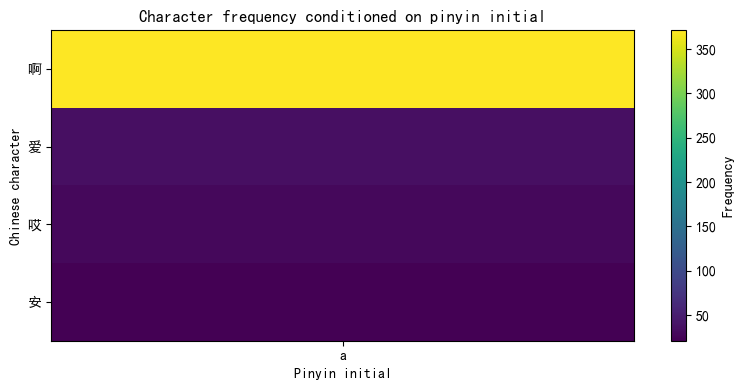

       b
不    417
吧    106
比     89
别     78
边     71
北     63
被     39
本     38
八     36
部     34
包     34
把     33
饼     28
变     25
爸     22
兵     22


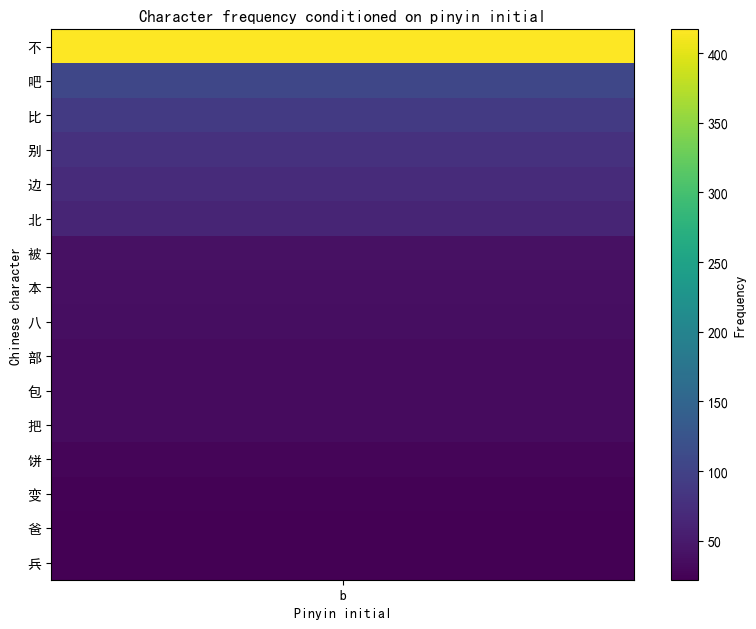

       c
吃    227
朝    109
成    105
出     90
常     68
春     44
次     42
从     39
才     33
错     32
传     29
菜     24
藏     21
产     21
楚     18
臭     17
城     17
炒     16
初     16
船     16
称     13
此     13
程     12


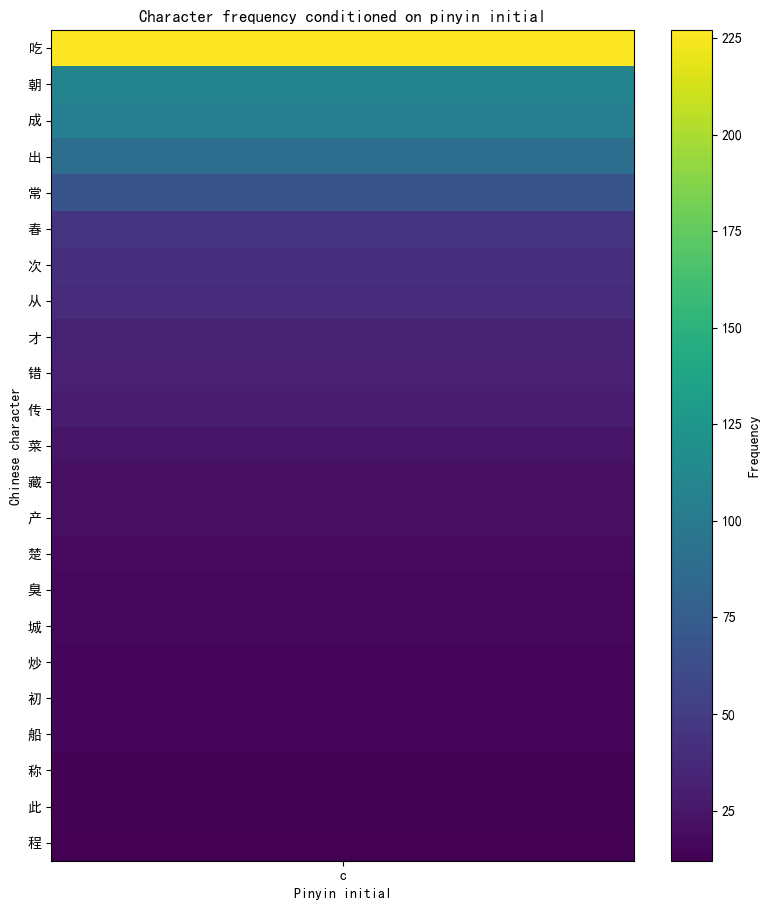

       d
的   1356
对    342
都    215
大    172
多    128
得    116
但    116
到    108
当    102
地     95
代     90
点     82
打     71


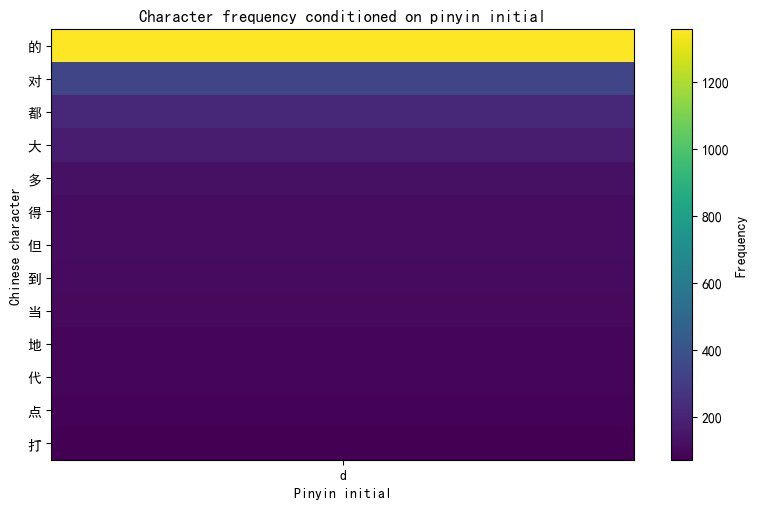

       e
呃    260
儿    179
而     56
二     29
恩     18


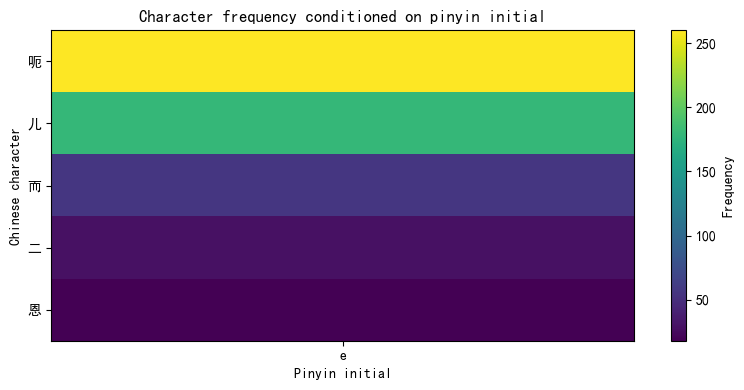

       f
方     74
非     66
发     53
法     47
反     44
分     41
饭     27
腐     27
放     23
夫     19
繁     17
封     10
防     10
风      9
藩      7
伐      7
份      6
丰      6
费      6
佛      6
飞      6
翻      6
服      5
纷      5
父      5
府      5
峰      5
帆      4
复      4
仿      4


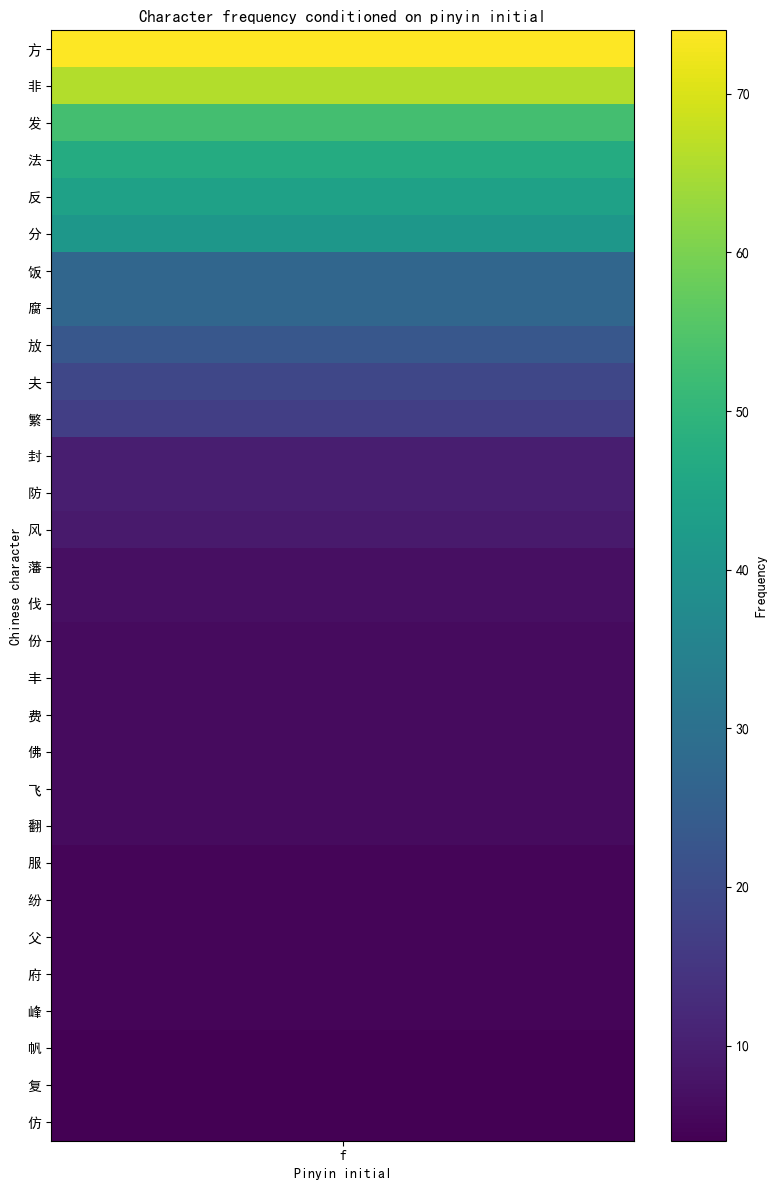

       g
个    926
国    380
过    132
感     69
高     57


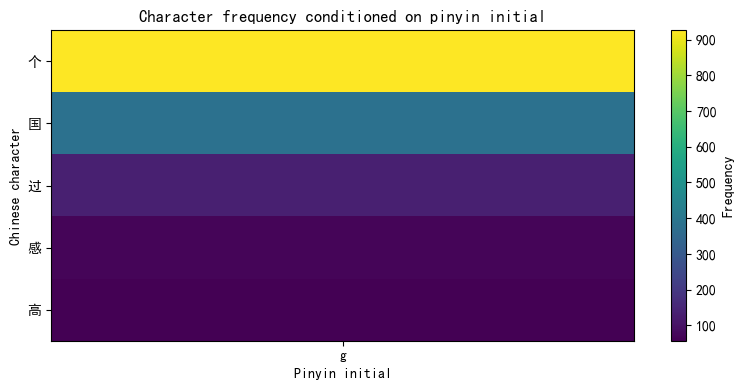

       h
后    332
好    276
还    176
很    138
候    122
会     96
和     77
害     62
海     55
华     45
皇     42
欢     39
话     38
化     35
火     29
湖     22
合     21
或     20
回     17


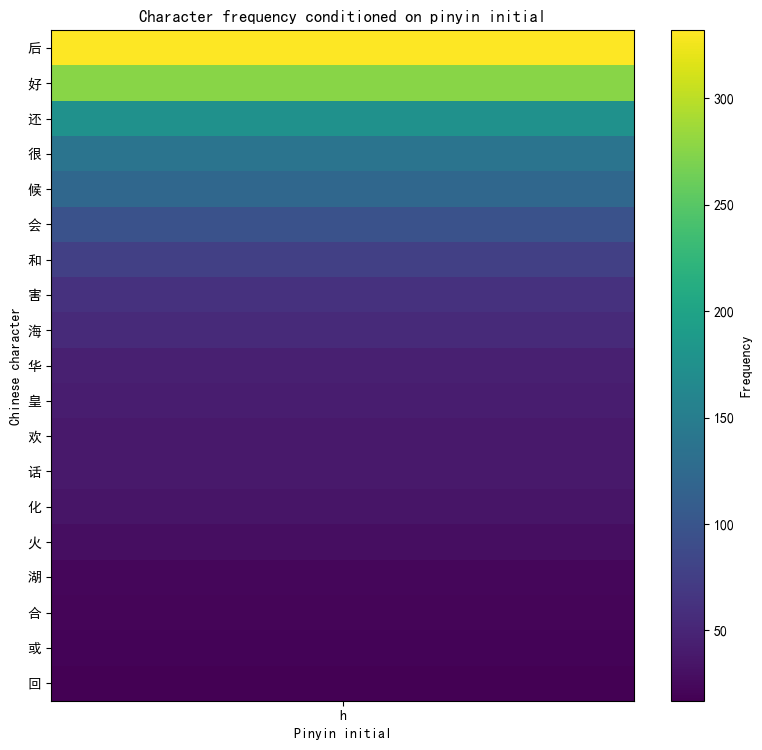

Skipping initial 'i' as no characters are present.
       j
就    688
家    154
觉    111
经     69
较     68
建     43
九     41
军     35


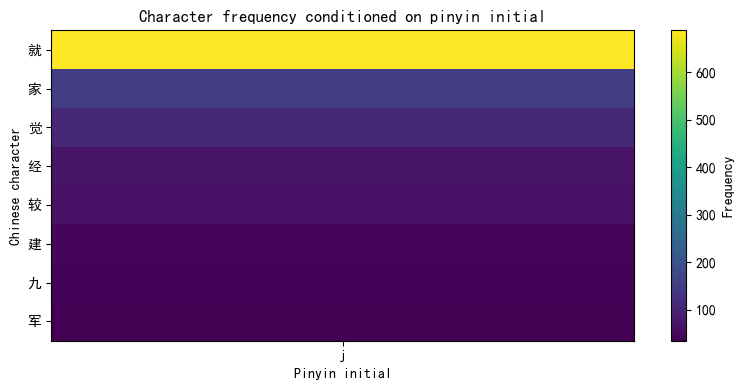

       k
可    192
看    123
开     59
肯     35
抗     23
快     20


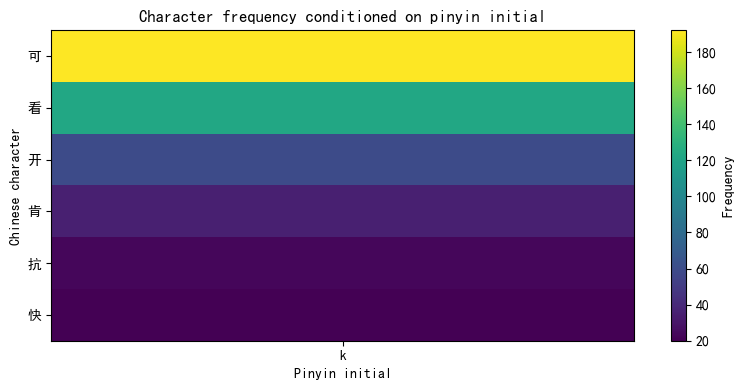

       l
了    517
来    201
里     88
厉     57
历     56
林     55
力     53
立     48
龙     48
两     41
刘     37
老     31
李     28


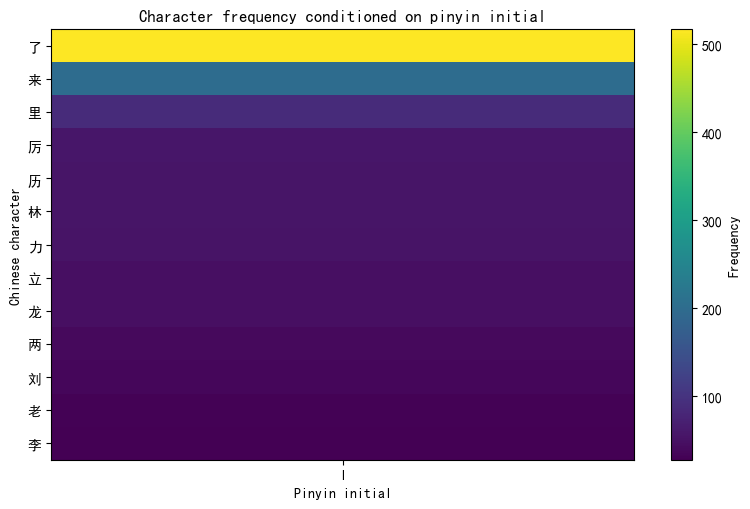

       m
们    267
么    148
面    113
嘛    109
没    107
民     60
每     43
吗     39
门     37
美     36
名     33
买     33
明     32
毛     24
妈     24
灭     15
米     14
蒙     14


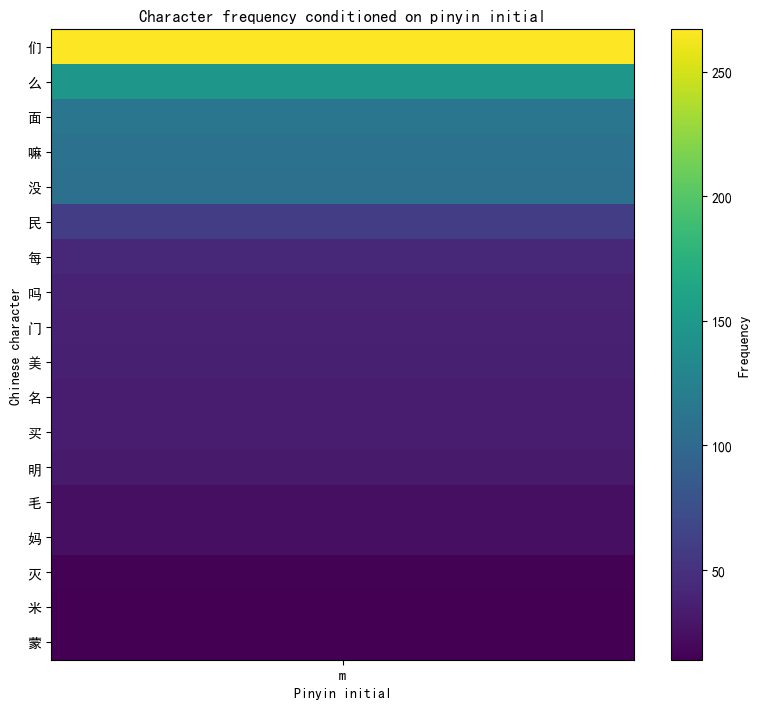

       n
那    894
嗯    355
你    189
年    106
能     92
呢     76
南     63


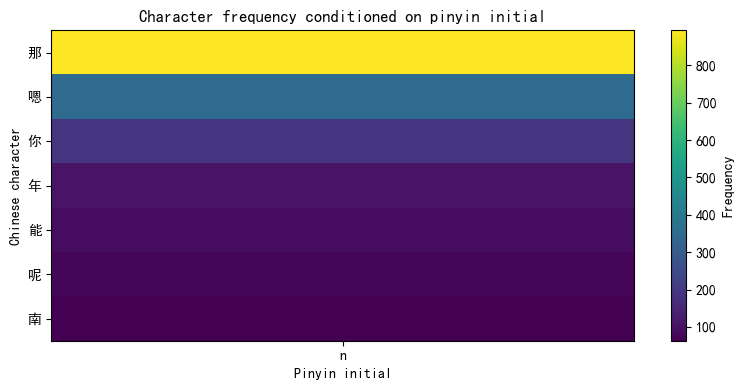

       o
哦     39
偶      2


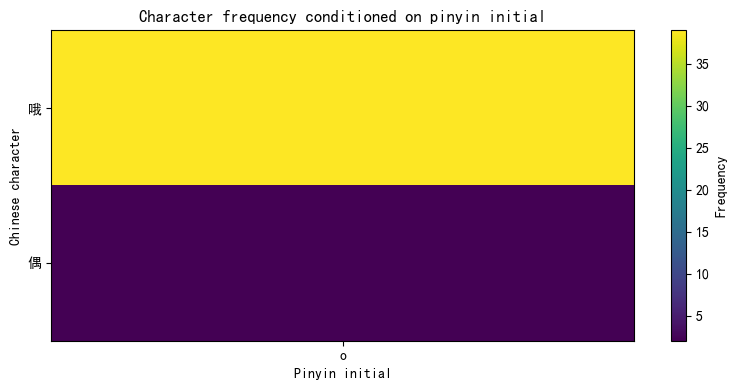

       p
平     37
派     23
片     22
怕     17
皮     11
瀑     11
拍     10
佩      9
破      8
品      7
坡      5
泡      5
叛      4
评      4
旁      3
婆      3
漂      3
排      3
碰      3
埔      3
辟      3
匹      3
魄      3
跑      2
票      2
铺      2
篇      2
胖      2
配      2


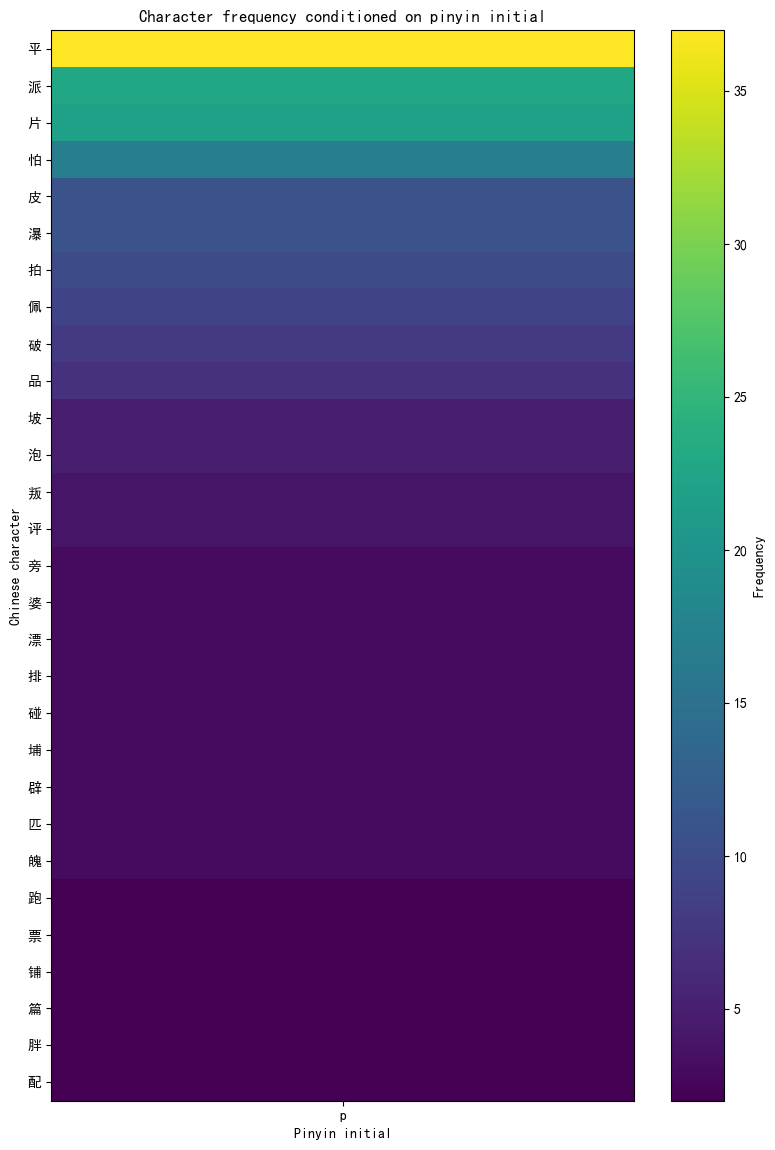

       q
去    188
起     87
秦     61
拳     59
期     52
前     32
强     30
秋     29
全     29
清     27
七     26
其     25
齐     22
气     21
确     17
亲     16
青     15
权     15
情     14
钱     14
区     11
且     10


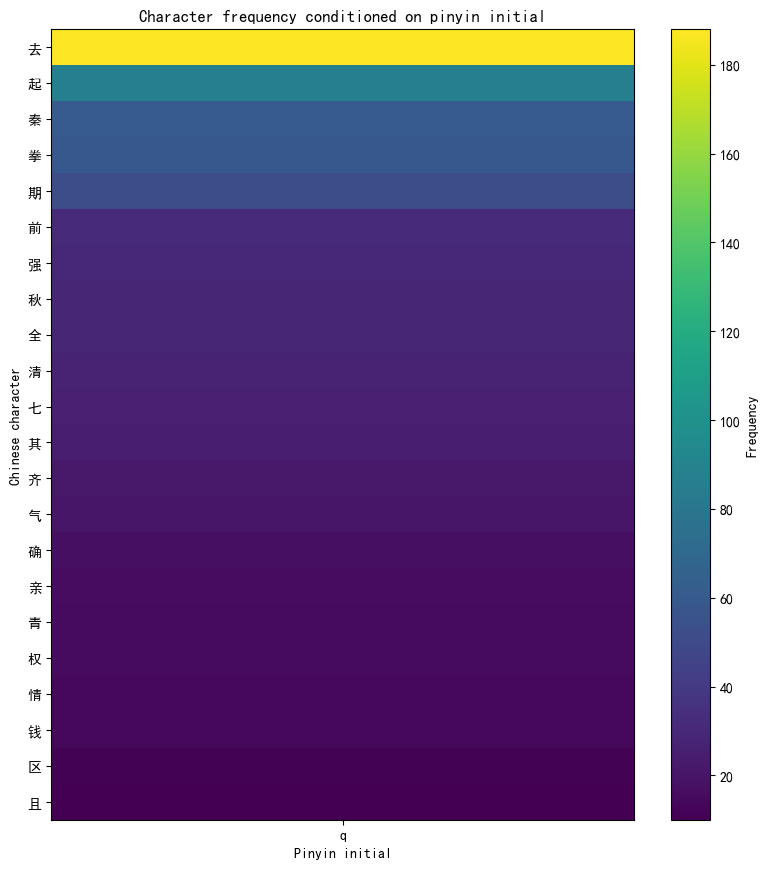

       r
人    299
然    219
肉     56
如     44
日     38
让     27
热     26
入     18


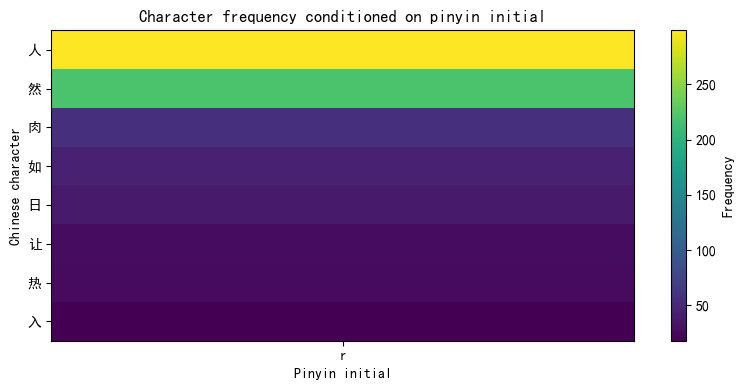

       s
是   1174
时    283
说    219
上    131
啥     87
什     87
山     85
十     80
少     64
史     61


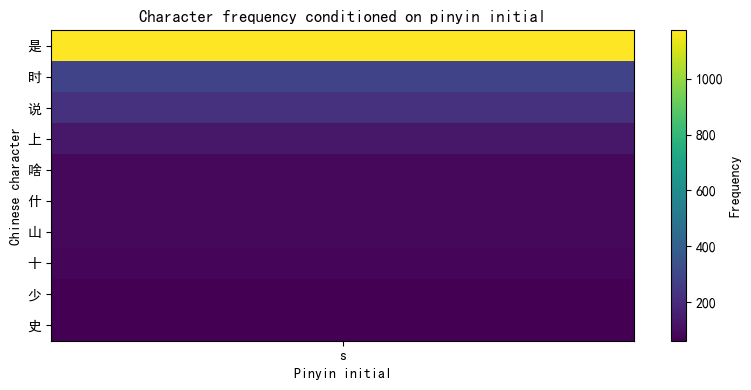

       t
他    388
它     92
天     71
太     59
统     57
特     55
挺     42
唐     35
头     23
她     21
体     20


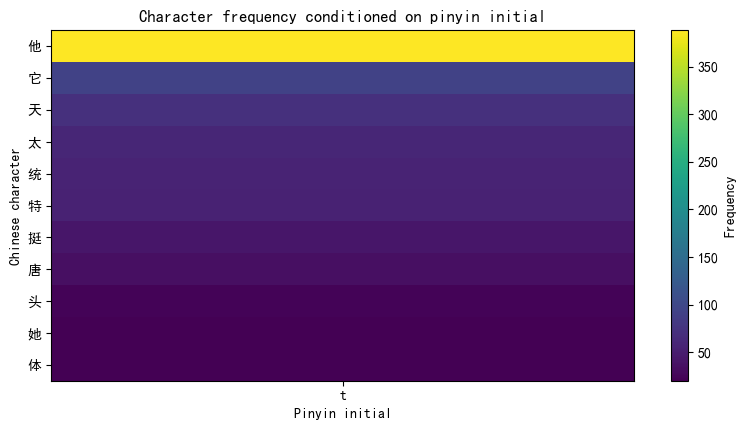

Skipping initial 'u' as no characters are present.
Skipping initial 'v' as no characters are present.
       w
我    444
为    157
武     86
王     71
外     46
文     46
五     45
位     37
物     26
问     23


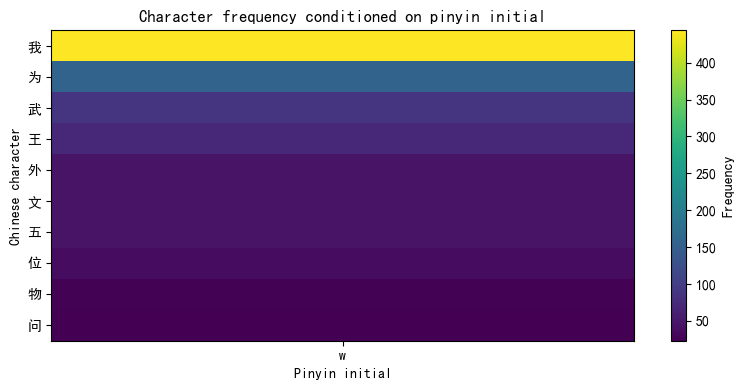

       x
些    213
像    135
想    106
小     91
下     80
现     76
行     55
学     44
西     43
喜     40
许     26
心     24
项     18
雄     17
星     16
香     16
馅     16
夏     15
新     14
雪     13
写     13
形     12
先     12
相     11
向     11


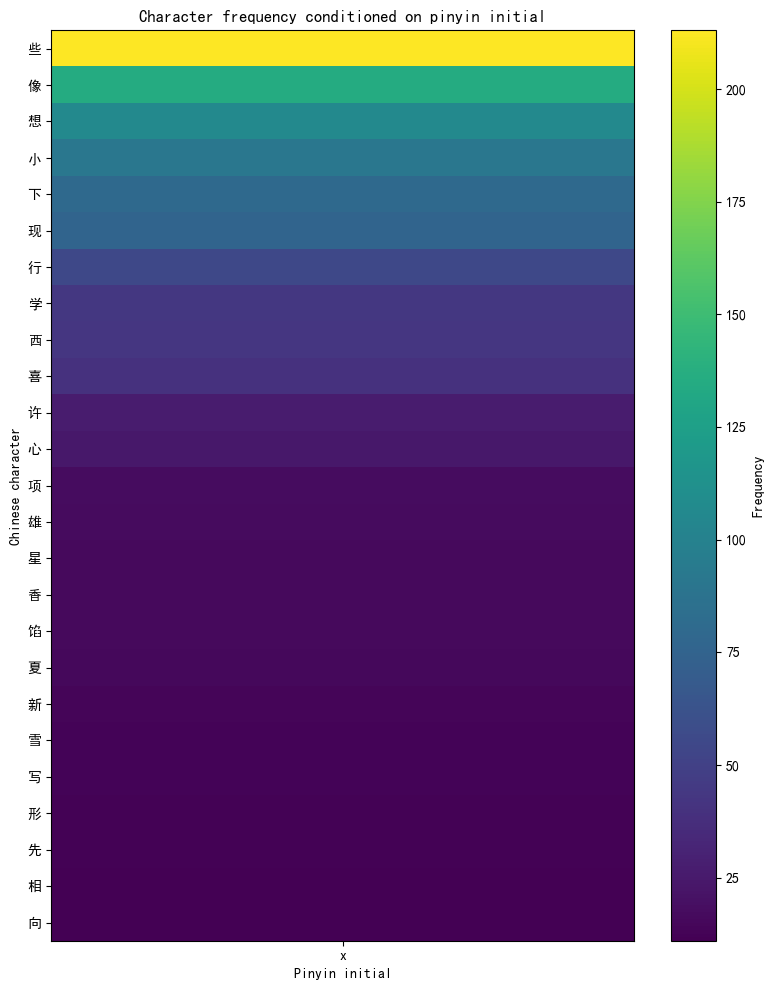

       y
一    598
有    479
也    246
呀    186
以    165
于     71
因     68
要     60
样     53
应     46
用     40
又     37
游     30


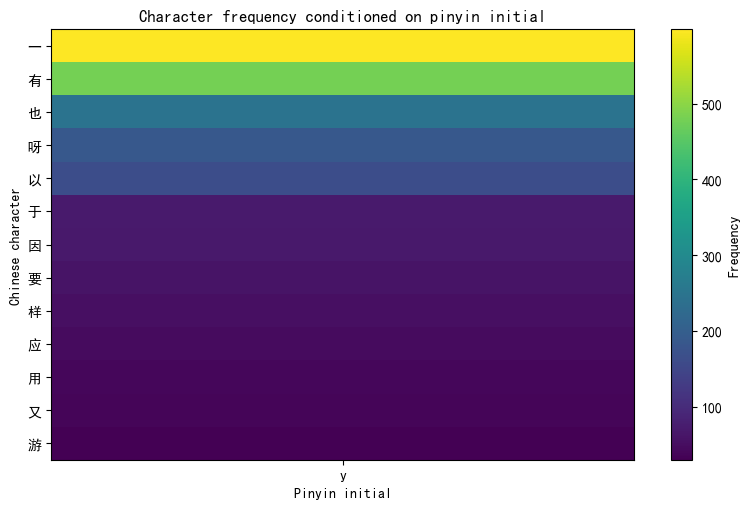

       z
这    409
在    289
中    221
种    195
战     87
最     86
子     84
之     80
着     75
正     70
自     66
长     66
咱     61
周     59
做     58
知     56
真     52
主     45
争     36
只     35
政     33
展     28
族     28
治     28
者     27
直     24
早     23
赵     22
制     22
重     22
张     21


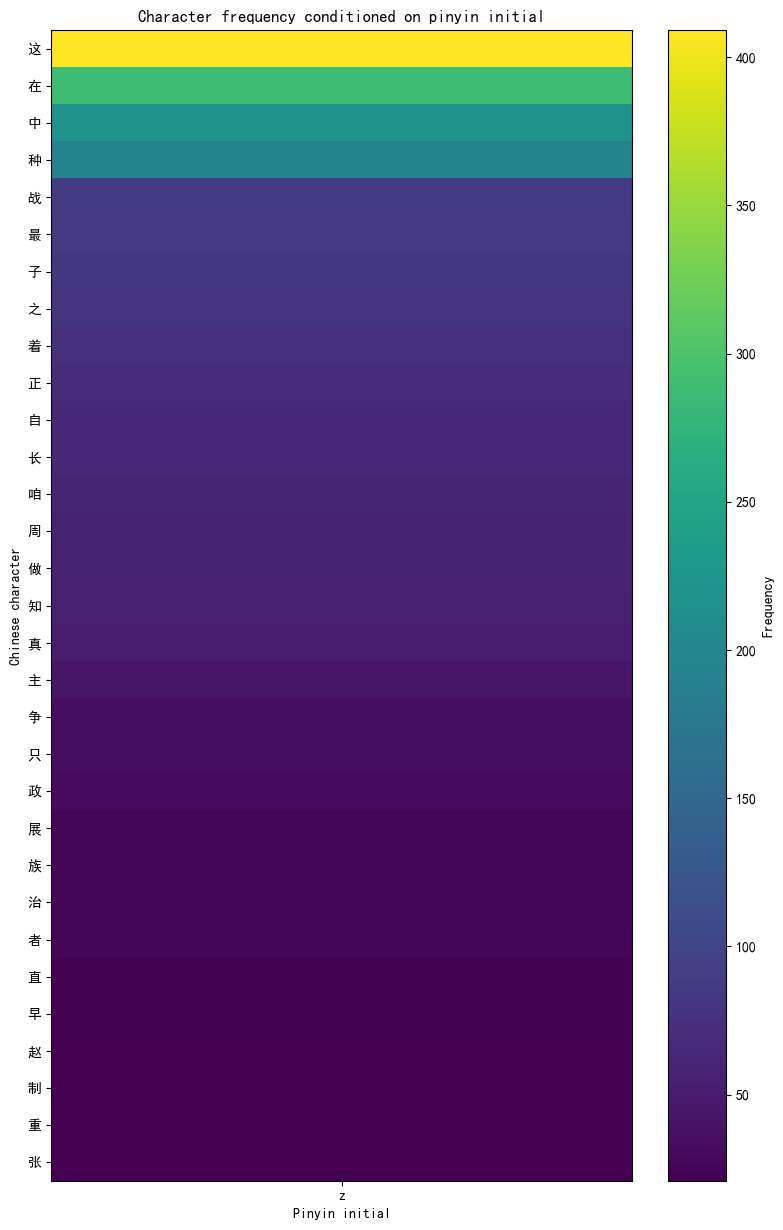

In [25]:
# ---------- 5. Example usage ----------

if __name__ == "__main__":
    # Example training data.
    # Replace this with your own corpus (webtoons, BabyLM, etc.).
    training_texts = zho_text_cleaned

    # 1) Build counts
    initial_to_counts = build_initial_to_char_counts(training_texts)

    # Ensure the output directory exists
    output_dir = "zho_frequency"
    os.makedirs(output_dir, exist_ok=True)

    # 2) Define initials and characters of interest
    # Include all letters of the alphabet as initials
    initials_of_interest = list(string.ascii_lowercase)

    for initial in initials_of_interest:
        # Check if the initial exists in the data
        if initial not in initial_to_counts or not initial_to_counts[initial]:
            print(f"Skipping initial '{initial}' as no characters are present.")
            continue
        

         # Dynamically determine characters within 10% frequency of the most frequent term
        most_frequent_count = initial_to_counts[initial].most_common(1)[0][1]
        cutoff = most_frequent_count * 0.05  # 5% of the most frequent count
        extra_chars = [ch for ch, count in initial_to_counts[initial].items() if count >= cutoff]

        # Dynamically determine the most frequent characters for the current initial
        # extra_chars = list(initial_to_counts[initial].keys())

        # extra_chars = []
        # if initial in initial_to_counts:
        #     # Get the most frequent character for the current initial
        #     most_frequent_char, _ = initial_to_counts[initial].most_common(1)[0]
        #     extra_chars.append(most_frequent_char)

        # 3) Build matrix (top 5 chars for the current initial + extra_chars)
        initials, chars, mat = build_matrix(
            initial_to_counts,
            initials=[initial],  # Only include the current initial
            extra_chars=extra_chars,
            top_k_per_initial=0,
        )

        # 4) Print table in the desired format
        print_matrix(initials, chars, mat)

        # 5) Save heatmap for the current initial
        heatmap_path = os.path.join(output_dir, f"{initial}.png")
        show_heatmap(initials, chars, mat)
        plt.savefig(heatmap_path)
        plt.close()